## Generating Explanation using TreeSurrogate (Classification/Regression)

### 1. Classification example using Iris dataset

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)
X = df
y = iris.target

In [2]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=5, class_weight="balanced", oob_score=True, random_state=1)
clf.fit(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [3]:
clf.feature_importances_

array([0.33239175, 0.03907281, 0.38180386, 0.24673158])

In [4]:
y_hat = clf.predict(X_test)

In [5]:
from sklearn.metrics import classification_report

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       1.00      1.00      1.00        15
    class 2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        50



In [6]:
print(np.unique(y_hat))
print(np.unique(y_test))

[0 1 2]
[0 1 2]


In [7]:
from skater.core.explanations import Interpretation
#from skater.core.global_interpretation.tree_surrogate import TreeSurrogate
from skater.util.dataops import show_in_notebook

interpreter = Interpretation(X_test, feature_names=iris.feature_names)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(estimator_type='classifier', 
                                                 feature_names=iris.feature_names, 
                                                 class_names=iris.target_names, seed=5)

In [8]:
# Using the surrogate model learn the decision boundaries learned by the base estimator
# Also report fidelity value when compared to the base estimator
# Learner uses F1 metric as the default metric of choice for classification.
surrogate_explainer.learn(X_test, y_hat, oracle_y=y_test)

2018-08-15 23:25:48,467 - skater.model.base - WARNING - No examples provided, cannot infer model type


0.0

In [9]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], file_name='simple_tree.png')

2018-08-15 23:25:50,709 - skater.util.dataops - INFO - File Name: simple_tree.png


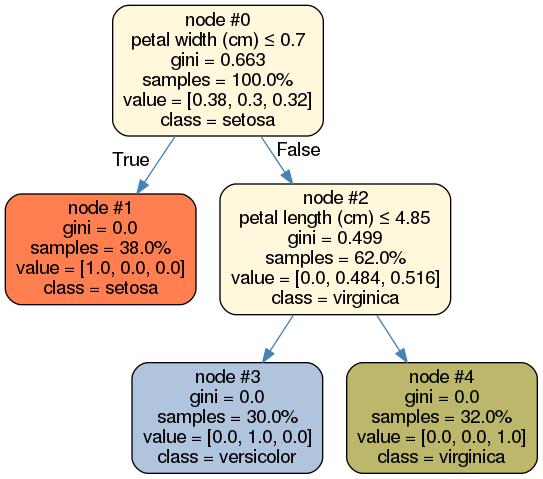

In [10]:
show_in_notebook('simple_tree.png', width=400, height=300)

In [11]:
surrogate_explainer.decisions_as_txt()

if petal width (cm) <= 0.699999988079071 {
    Predicted Label: 0
} else {
  if petal length (cm) <= 4.850000381469727 {
      Predicted Label: 1
  } else {
      Predicted Label: 2
  }
}


#### Evaluating individual prediction

In [12]:
sample_index = 6
X_test.iloc[sample_index]

sepal length (cm)    5.6
sepal width (cm)     2.9
petal length (cm)    3.6
petal width (cm)     1.3
Name: 6, dtype: float64

In [13]:
print("Oracle Model {}:".format(clf.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [1]:
Using TreeSurrogate [1]:


In [14]:
surrogate_explainer.decisions_as_txt('local', X_test.iloc[sample_index])

As petal width (cm)[1.3] > 0.699999988079071 then,
  As petal length (cm)[3.6] <= 4.850000381469727 then,
      Predicted Label: 1


### 2. Regression example

In [15]:
from sklearn.datasets import load_boston
from sklearn.ensemble.forest import RandomForestRegressor
boston = load_boston()

# Create a dataframe with the four feature variables
df = pd.DataFrame(boston.data, columns=boston.feature_names)
X = df
y = boston.target

# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

est = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)
est.fit(X_train, y_train)

y_hat_reg = est.predict(X_test)

# Using R^2(Coefficient of Determination for evaluation)
from sklearn.metrics import r2_score
r2_score(y_test, y_hat_reg)

0.8241067799403499

In [16]:
interpreter_reg = Interpretation(X_test, feature_names=boston.feature_names)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer_reg = interpreter_reg.tree_surrogate(estimator_type='regressor', 
                                                         feature_names=boston.feature_names, seed=5)

In [17]:
# The score returned is the fidelity score = difference in performance between the values returned by the Oracle and
# the surrogate model. If the difference is big then the surrogate model most likely is not a good representation
# of the base model.
surrogate_explainer_reg.learn(X_test, y_hat_reg, n_iter_search=10, oracle_y=y_test, scorer_type='r2')

2018-08-15 23:26:30,387 - skater.model.base - WARNING - No examples provided, cannot infer model type
2018-08-15 23:26:30,388 - skater.core.global_interpretation.tree_surrogate - WARNING - fidelity score:0.07330421598208592 of the surrogate model is higher than the impurity threshold: 0.01


0.07330421598208592

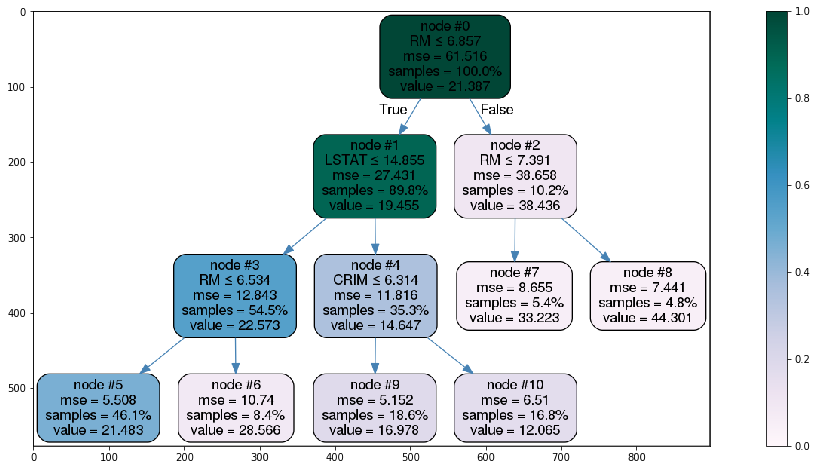

In [18]:
%matplotlib inline
surrogate_explainer_reg.plot_global_decisions(file_name='simple_tree_reg.png')

2018-08-15 23:26:33,971 - skater.util.dataops - INFO - File Name: simple_tree_reg.png


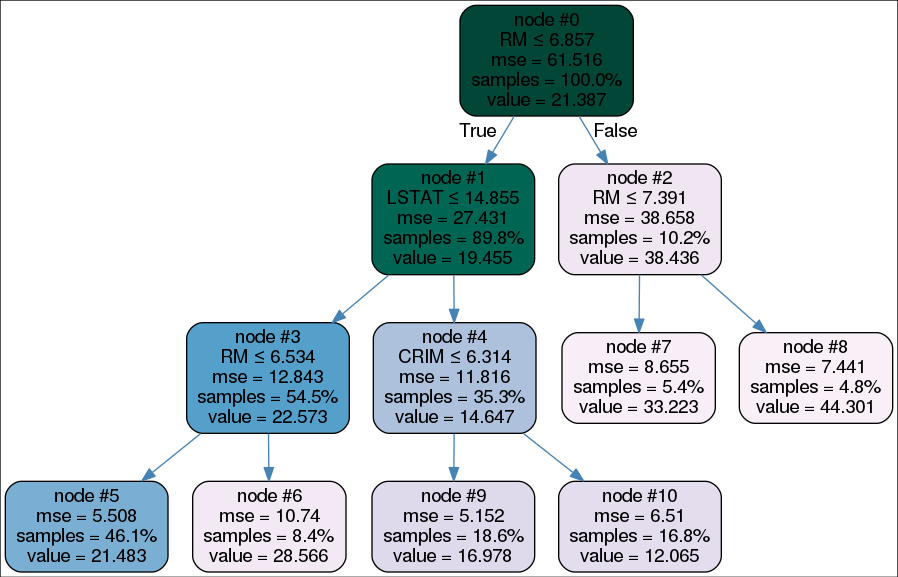

In [19]:
show_in_notebook('simple_tree_reg.png')

#### Evaluating individual prediction

In [20]:
sample_index = 6
X_test.iloc[sample_index]

CRIM         0.31827
ZN           0.00000
INDUS        9.90000
CHAS         0.00000
NOX          0.54400
RM           5.91400
AGE         83.20000
DIS          3.99860
RAD          4.00000
TAX        304.00000
PTRATIO     18.40000
B          390.70000
LSTAT       18.33000
Name: 6, dtype: float64

In [21]:
print("Oracle Model {}:".format(est.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer_reg.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [20.03]:
Using TreeSurrogate [16.9783871]:


In [22]:
surrogate_explainer_reg.decisions_as_txt('local', X_test.iloc[sample_index])

As RM[5.914] <= 6.856500148773193 then,
  As LSTAT[18.33] > 14.854999542236328 then,
    As CRIM[0.31827] <= 6.314260005950928 then,
        Value: [[16.9783871]]
